In [4]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.datasets import fetch_olivetti_faces

This example shows a code to download an image data set.

The images are treated like snapshots of a fluid flow.
 

(4096, 400)


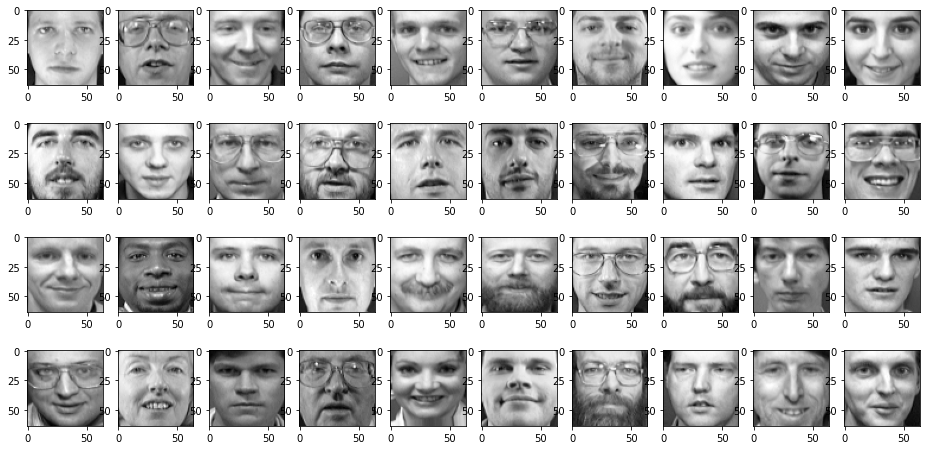

In [5]:

# download the face images

faces = datasets.fetch_olivetti_faces()
U = faces.data

U = U.T
# Each column is an image of size 64 x 64 = 4096 numbers
print(U.shape)

# get unique id for each image
ids = np.unique(faces.target)

# plot 40 images
plt.subplots(nrows=4, ncols=10, figsize=(16,8))
for id in ids:
    plt.subplot(4,10,id+1)
    plt.imshow(U[:,id*10].reshape((64,64)),cmap='gray')

plt.show()




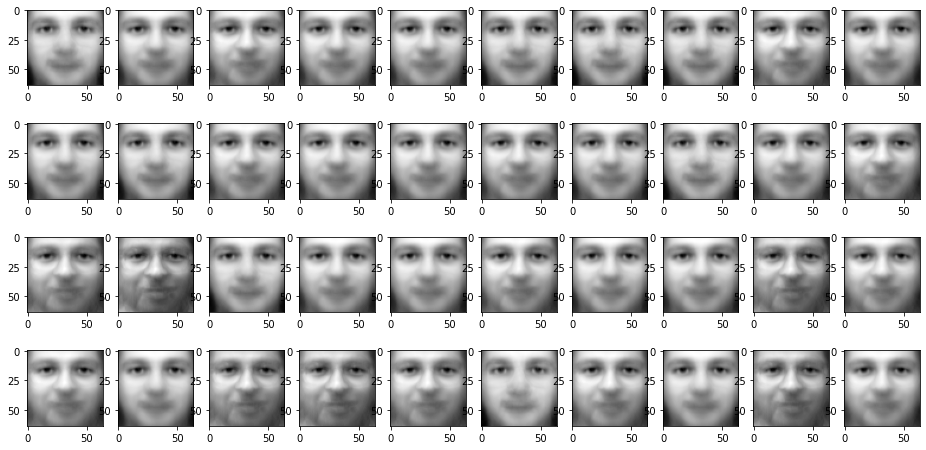

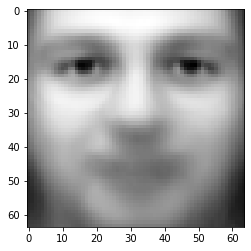

In [6]:
# Compute the mean of each image. 
# This mean is like the Reynolds decomposition of turbulence

Ubar = np.mean(U,axis=1,keepdims=1)

# Compute the POD modes of the fluctuation over mean
# This is like dealing with turbulence fluctuation

Phi, Sig, PsiT = np.linalg.svd(U-Ubar,full_matrices=0)

# Reconstruct the images using rank 1
# This is like POD projection of a fluid flow
r = 1
Upod = Ubar + np.linalg.multi_dot([Phi[:,0:r]* Sig[0:r],  PsiT[0:r,:]])

plt.subplots(nrows=4, ncols=10, figsize=(16,8))
for id in ids:
    plt.subplot(4,10,id+1)
    plt.imshow(Upod[:,id*10].reshape((64,64)),cmap='gray')

# Increase the value of r and compare the POD projection with the mean
plt.figure(4)
plt.imshow(Ubar.reshape((64,64)),cmap='gray')

plt.show()

In [8]:
# add some salt and papper 
# below is a commonly used algorithm to add white noise
sz = U.size
st = 0.2 # 10% noise

nz_dim = int(sz*st) # noise dimension

# Randomly select indices
# where sz is size of data matrix
# and nz_dim is length of noise data.
idx = np.random.choice(sz, nz_dim)

# Create a copy of the original matrix
# which is the noisy data.
Unoisy = U.copy()

# Create a random noise random between min and max values of the data.
noise = np.random.choice([U.min(), U.max()], nz_dim)

# Replace the values of the templated noised data
# at random indices with the noise, 
# to obtain the final noised data.
# note idx is a subset of indices of our data matrix
# if the data matrix is flat

Unoisy.flat[idx] = noise

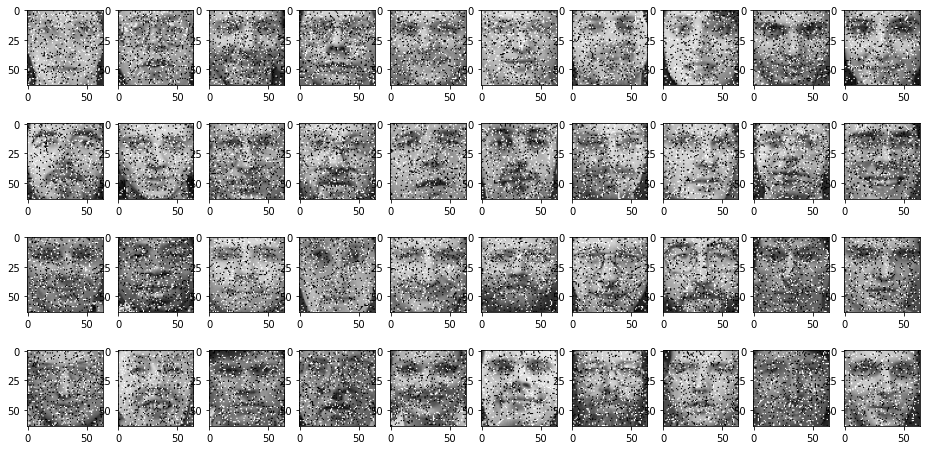

In [9]:
plt.subplots(nrows=4, ncols=10, figsize=(16,8))
for id in ids:
    plt.subplot(4,10,id+1)
    plt.imshow(Unoisy[:,id*10].reshape((64,64)),cmap='gray')

In [11]:
# apply a threshold to a vector
# if U = sin(2*pi*x) and eps=0.25
# the following algorithm will reduce 
# all values of U towards zero by an amount of 0.25
def threshold(U,eps):
    # remove all values smaller than esp

    V = np.abs(U)-eps
    
    return np.sign(U) * np.maximum(V,np.zeros_like(V))

# find an approximation based on the coherent motion
# apply singular value decomposition of a matrix U
# threshold the singular values with eps
# reconstruct the matrix V
# the result V is the best approximation 
# with respect to thresholded POD modes

def best_pod_modes(U,eps):
    # SVD
    Phi,Sig,PsiT = np.linalg.svd(U,full_matrices=0)
    
    # soft threshold
    rSig = threshold(Sig,eps)

    # reconstruct
    V = np.linalg.multi_dot([Phi*rSig,PsiT])

    return V

def coherence_detection(U, iter):
    # U is n x m matrix
    n, m = U.shape

    # assign mu (penalty), lambda, delta
    mu = n * m/(4*np.sum(np.abs(U.reshape(-1))))
    lambd = 1/np.sqrt(np.maximum(n, m))
    delta = 10**(-7) * np.linalg.norm(U)

    # initialize matrices
    # incoherent part
    Ui = np.zeros_like(U)
    
    # Lagrange multiplier auxiliary part for ADMM
    Y = np.zeros_like(U)
    
    # coherent part
    Uc = np.zeros_like(U)

    # start iteration
    count = 0
    while (np.linalg.norm(U-Uc-Ui) > delta) and (count < iter):

        # predict the coherent motion based on the best pod modes
        Uc = best_pod_modes(U-Ui+(1/mu)*Y,1/mu)

        # apply a threshold into the incoherent motion
        Ui = threshold(U-Uc+(1/mu)*Y,lambd/mu)

        # update the Lagrange multiplier
        Y = Y + mu*(U-Uc-Ui)
        count += 1
        
    return Uc,Ui


In [19]:
#t0 = time.process_time()
Uc, Ui = coherence_detection(Unoisy, 150)
#t1 = time.process_time()

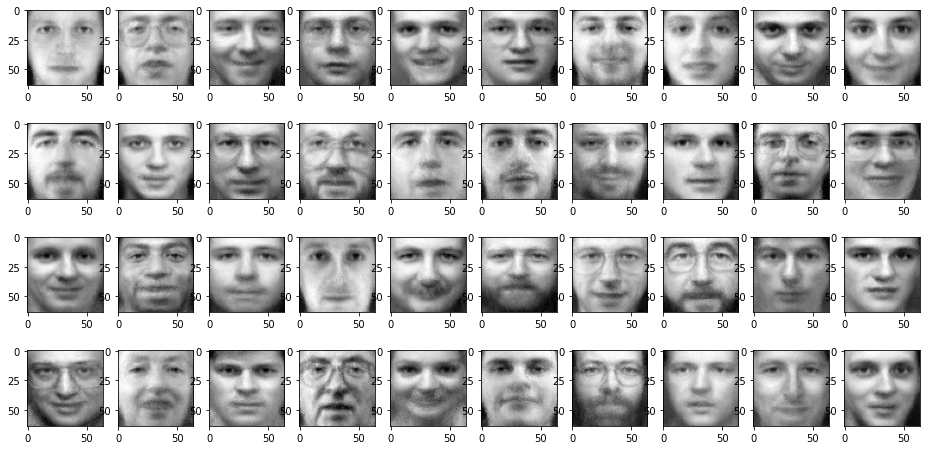

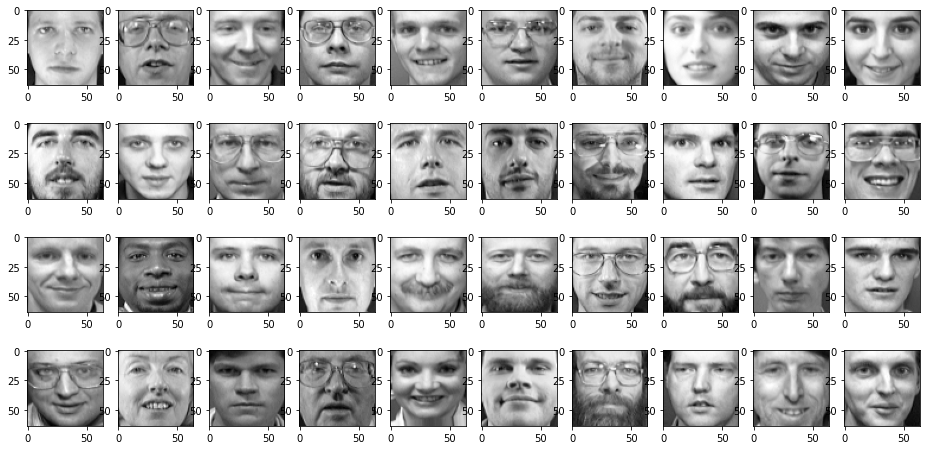

In [24]:
plt.subplots(nrows=4, ncols=10, figsize=(16,8))
for id in ids:
    plt.subplot(4,10,id+1)
    plt.imshow(Uc[:,id*10].reshape((64,64)),cmap='gray')

plt.subplots(nrows=4, ncols=10, figsize=(16,8))
for id in ids:
    plt.subplot(4,10,id+1)
    plt.imshow(U[:,id*10].reshape((64,64)),cmap='gray')